# «Quantitative Evaluation of XAI Methods for Image Segmentation in Autonomous Driving»

### Bachelor Thesis Implementation - Model (Phase 1) 
Liridona Cerkini - 
Rotkreuz, May 30th, 2025

### Intro 
This notebook documents Phase 2 of the research, focusing on the evaluation of Explainable AI (XAI) methods for semantic segmentation in autonomous driving scenarios. Building upon the model application in Phase 1, where uncompressed images were segmented using OneFormer, this phase aims to assess various XAI techniques in terms of interpretability and effectiveness.

The selected XAI methods include LIME, Grad-CAM, Seg-Grad-CAM, Guided Grad-CAM, Saliency (Vanilla Gradient), XRAI and L-CRP. The selection is based on their methodological diversity, empirical performance, and relevance to image segmentation tasks. LIME, Grad-CAM, and Seg-Grad-CAM have demonstrated strong results in prior research, while methods like XRAI and L-CRP introduce novel region-based and layered attribution approaches that enhance interpretability.

### Objectives
- Validate model performance on a complex segmentation task.
- Evaluate the universal model's effectiveness in semantic segmentation tasks.

### Data
- 805 images from the Mapillary Vistas dataset (Neuhold et al., 2017).
- Segmentation performed using OneFormer.

### Methodology 
Quality Assessment: Evaluating IoU for uncompressed images, focusing on a subset of six labels with similar frequencies.

### Datasets Used:
- Neuhold, G., Ollmann, T., Bulo, S. R., & Kontschieder, P. (2017). The Mapillary Vistas Dataset for Semantic Understanding of Street Scenes. 2017 IEEE International Conference on Computer Vision (ICCV), 5000–5009. https://doi.org/10.1109/ICCV.2017.534

### Additional Sources:
- OneFormer: http://arxiv.org/abs/2211.06220
- HuggingFace: https://huggingface.co/
- OneFormer Benchmark (via Paperswithcode): https://paperswithcode.com/paper/oneformer-one-transformer-to-rule-universal

### Importing Libraries

In [1]:
!pip install transformers
import torch
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
!pip install datasets
from datasets import load_dataset
from PIL import Image
import requests
import glob


from tqdm import tqdm

import numpy as np
import scipy.stats as stats

import os
from __future__ import print_function
import json
import gc

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### Importing Dataset

Initially, the subset was directly imported into the images and labels directories. The images were pre-selected locally by size (3264x2448) since the model requires a consistent image size. Padding or other cropping methods could distort segmentation results, which is why they were avoided. The images are not filtered by size within the notebook to avoid unnecessary loading times.

Stream-Reading was not used in this case because the Mapillary Vistas dataset is not available on Hugging Face. However, in a separate project, it was found that OneFormer performs better with stream-reading across all classes, particularly with well-defined objects like cars and persons. OneFormer appears to handle compressed or downscaled images better, which explains its superior performance in stream-reading. These results, however, are based on a different dataset, so they may not be directly applicable to the Mapillary Vistas dataset. This approach would be enabled via Hugging Face by using the parameter streaming=True (i.e., load_dataset("....", streaming=True)).

In [2]:
image_dir = "images"
image_count = len([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))])
print(f"Number of images: {image_count}")

Number of images: 805


In [3]:
image_dir = "labels"
image_count = len([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))])
print(f"Number of label images: {image_count}")

Number of label images: 805


In [4]:
image_folder = "images"
ds = []

for i, filename in enumerate(sorted(os.listdir(image_folder))):
    filepath = os.path.join(image_folder, filename)
    if filename.endswith((".png", ".jpg", ".jpeg")):
        img = Image.open(filepath).convert("RGB")
        ds.append(img)

In [5]:
labels_folder = "labels"
dsseg = []

for i, filename in enumerate(sorted(os.listdir(labels_folder))):
    filepath = os.path.join(labels_folder, filename)
    if filename.endswith((".png", ".jpg", ".jpeg")):
        img = Image.open(filepath)
        dsseg.append(img)

In [6]:
# Select the first 805 images from each dataset  
ds_subset = ds[:805]  
ds_subset_seg = dsseg[:805]  

In [7]:
# Previous code filtered by image size. Now, all images in the folder are already the same size.  

#ds_subset = []
#ds_subset_seg = []

# Iterate through both datasets simultaneously
#for img, img_seg in zip(ds, dsseg):
    # Check if the image size matches and the subset limit is not exceeded
    #if img.size == (3264, 2448) and len(ds_subset) < 200:
        #ds_subset.append(img)
    # Check if the segmentation label size matches and the subset limit is not exceeded
    #if img_seg.size == (3264, 2448) and len(ds_subset_seg) < 200:
        #ds_subset_seg.append(img_seg)
    # Stop iteration early if both subsets have reached the limit
    #if len(ds_subset) >= 200 and len(ds_subset_seg) >= 200:
        #break

In [8]:
# Display the first five elements of the list
ds_subset[:5] 

[<PIL.Image.Image image mode=RGB size=3264x2448>,
 <PIL.Image.Image image mode=RGB size=3264x2448>,
 <PIL.Image.Image image mode=RGB size=3264x2448>,
 <PIL.Image.Image image mode=RGB size=3264x2448>,
 <PIL.Image.Image image mode=RGB size=3264x2448>]

In [9]:
# Display the first five elements of the list
ds_subset_seg[:5] 

[<PIL.PngImagePlugin.PngImageFile image mode=P size=3264x2448>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=3264x2448>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=3264x2448>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=3264x2448>,
 <PIL.PngImagePlugin.PngImageFile image mode=P size=3264x2448>]

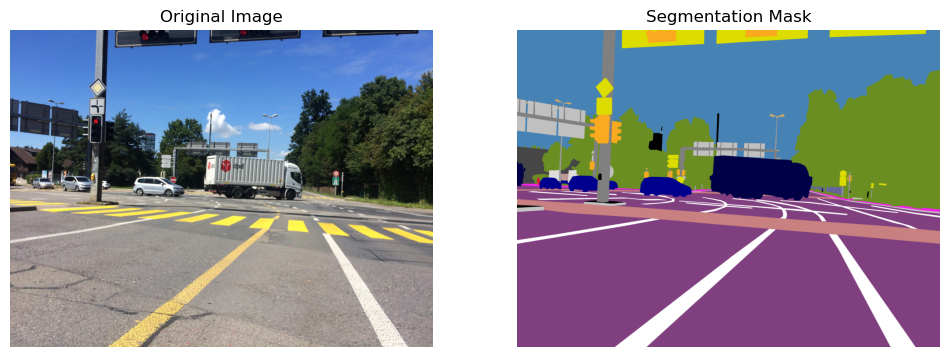

In [10]:
# Retrieve the first image and its corresponding segmentation mask
first_image = ds[0]  # First image from the list
first_label = dsseg[0]  # First segmentation mask

# Display images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(first_image)
plt.title("Original Image")
plt.axis("off")

# Segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(first_label, cmap="jet")  # Enhances mask visibility with colors
plt.title("Segmentation Mask")
plt.axis("off")

plt.show()

### Check Memory

In [11]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get GPU details
    device = torch.device("cuda")
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    # Calculate free memory
    free_memory = total_memory - allocated_memory
    print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated GPU Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free GPU Memory: {free_memory / (1024 ** 3):.2f} GB")
    print(f"Cached GPU Memory: {cached_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Please check your GPU setup.")

Total GPU Memory: 14.54 GB
Allocated GPU Memory: 0.00 GB
Free GPU Memory: 14.54 GB
Cached GPU Memory: 0.00 GB


### Load pretrained Model

In [12]:
# Load OneFormer via Transformers
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation

processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_cityscapes_swin_large")
oneformer = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_cityscapes_swin_large")

/opt/conda/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `OneFormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [13]:
# Calculate memory requirements of the model
oneformer_memory = sum(p.numel() for p in oneformer.parameters())
print(f"OneFormer Model Memory: {oneformer_memory / (1024 ** 2):.2f} MB")

OneFormer Model Memory: 208.64 MB


In [14]:
# Move OneFormer model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
oneformer = oneformer.to(device)

# Verify the model is on the correct device
print(f"OneFormer model is now on: {device}")

OneFormer model is now on: cuda


In [15]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get GPU details
    device = torch.device("cuda")
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    # Calculate free memory
    free_memory = total_memory - allocated_memory
    print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated GPU Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free GPU Memory: {free_memory / (1024 ** 3):.2f} GB")
    print(f"Cached GPU Memory: {cached_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Please check your GPU setup.")

Total GPU Memory: 14.54 GB
Allocated GPU Memory: 0.82 GB
Free GPU Memory: 13.72 GB
Cached GPU Memory: 0.84 GB


Before loading the model, the total GPU memory was 14.54 GB, with no memory allocated. After loading the OneFormer model with 208.64 MB, a total of 0.82 GB of GPU memory is in use, while 13.72 GB remains free. The additional memory usage is due to PyTorch overhead and caching. The cached memory indicates that PyTorch has pre-allocated memory for future operations. Overall, there is sufficient GPU memory available for additional tasks, highlighting the efficiency of the model in relation to the total GPU memory.

The higher memory requirement of OneFormer can be attributed to its more complex architecture. OneFormer utilizes advanced technologies like transformer models, which require more parameters and a more intricate structure to handle universal segmentation tasks (semantic and panoptic segmentation, as well as instance segmentation).

### Ground Truth Segmentation des Cityscape Datasets

First, the "Ground Truth" is examined to determine the color of the detected objects. As part of this investigation, the following 6 labels (IDmv) are ultimately evaluated:

- 15 Sidewalk
- 19 Person
- 48 Traffic Light
- 50 Traffic Sign (Front)
- 52 Bicycle
- 55 Car 

For this purpose, two image are employed that include all six aforementioned objects:

- "bQs_9fstXdJ26wZ8mPyGGw.png" (includes 15, 19, 52, 55,...)
- "2IHA_OHJ7mCnyk9d0831ew.png" (includes 15, 48, 50, 55,...)

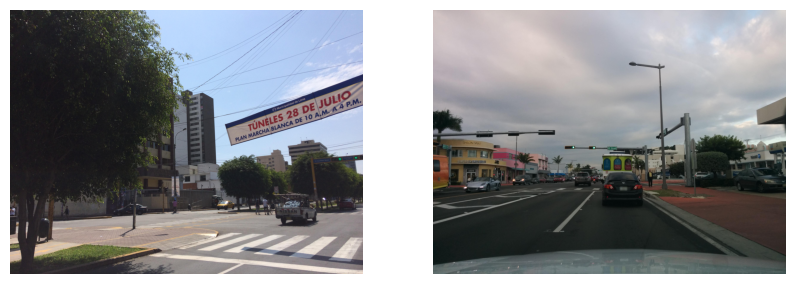

In [16]:
# Load both images
image1 = Image.open('images/bQs_9fstXdJ26wZ8mPyGGw.jpg')
image2 = Image.open('images/2IHA_OHJ7mCnyk9d0831ew.jpg')

# Display both images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
axes[0].imshow(image1)
axes[0].axis('off')  # Hide axes for the first image
axes[1].imshow(image2)
axes[1].axis('off')  # Hide axes for the second image

plt.show()

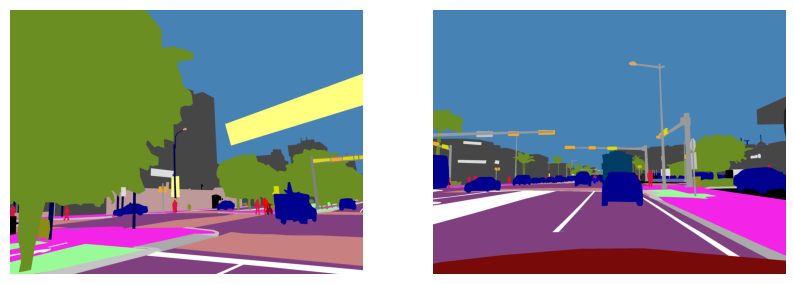

In [17]:
# Load both labels of both images
label1 = Image.open('labels/bQs_9fstXdJ26wZ8mPyGGw.png')
label2 = Image.open('labels/2IHA_OHJ7mCnyk9d0831ew.png')

# Display both images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
axes[0].imshow(label1)
axes[0].axis('off')  # Hide axes for the first image
axes[1].imshow(label2)
axes[1].axis('off')  # Hide axes for the second image

plt.show()

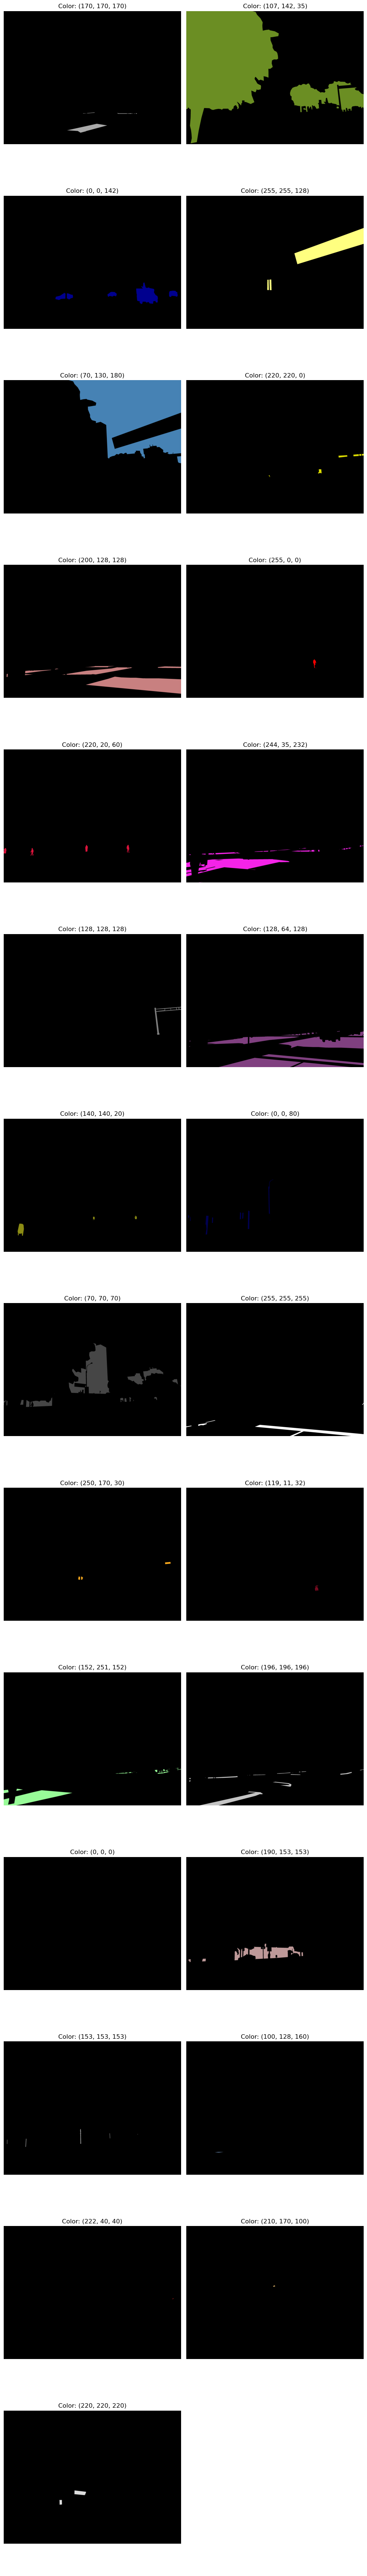

In [18]:
# Load the original image
original_image_path = "bQs_9fstXdJ26wZ8mPyGGw.png"
original_image = Image.open(original_image_path).convert("RGB")

# Extract unique colors from the original image
unique_colors = list(set(original_image.getdata()))

# Function to create an image containing only a specific color
def create_color_image(image, color):
    image_array = np.array(image)
    mask = np.all(image_array == color, axis=-1)
    new_image = np.zeros_like(image_array)
    new_image[mask] = color
    return Image.fromarray(new_image)

# Determine the number of rows and columns for displaying images
num_cols = 2
num_rows = -(-len(unique_colors) // num_cols)  # Round up the number of rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array

# Create and display a new image for each unique color
for idx, color in enumerate(unique_colors):
    row, col = divmod(idx, num_cols)
    color_image = create_color_image(original_image, color)
    axes[row, col].imshow(color_image)
    axes[row, col].set_title(f"Color: {color}")
    axes[row, col].axis("off")

# Hide unused axes
for idx in range(len(unique_colors), num_rows * num_cols):
    row, col = divmod(idx, num_cols)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

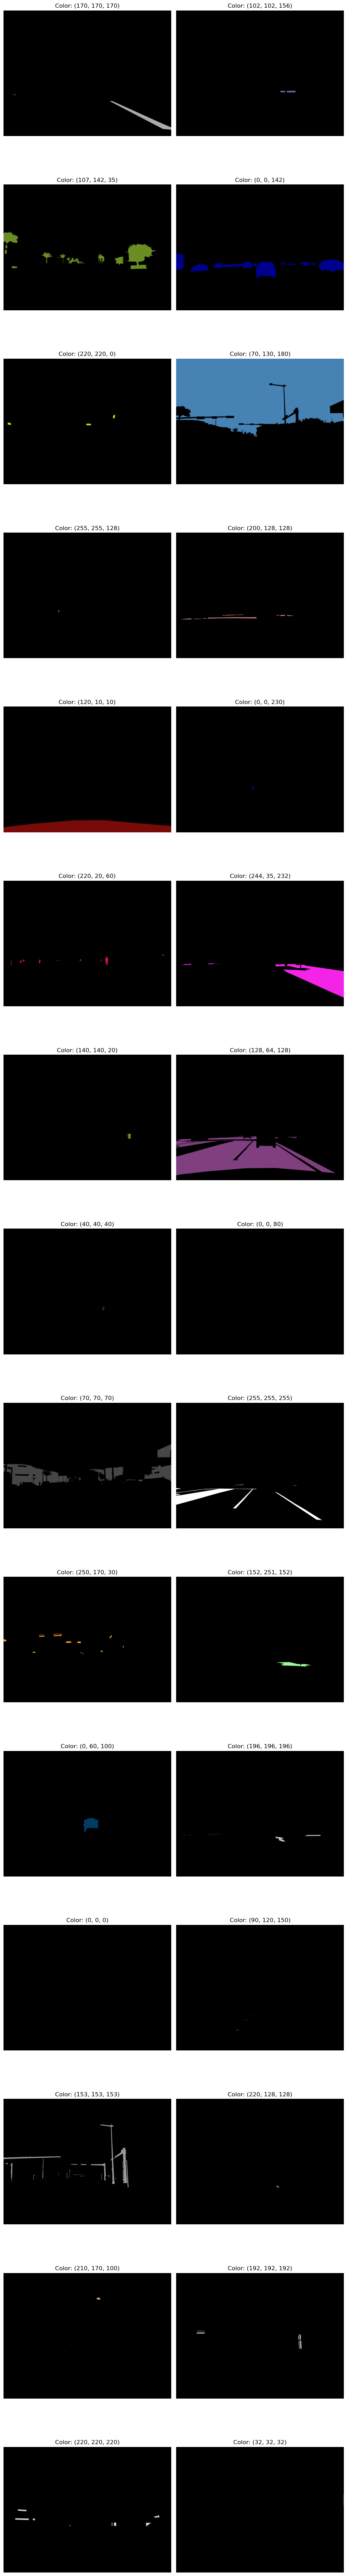

In [19]:
# Load the original image
original_image_path = "2IHA_OHJ7mCnyk9d0831ew.png"
original_image = Image.open(original_image_path).convert("RGB")

# Extract unique colors from the original image
unique_colors = list(set(original_image.getdata()))

# Function to create an image containing only a specific color
def create_color_image(image, color):
    image_array = np.array(image)
    mask = np.all(image_array == color, axis=-1)
    new_image = np.zeros_like(image_array)
    new_image[mask] = color
    return Image.fromarray(new_image)

# Determine the number of rows and columns for displaying images
num_cols = 2
num_rows = -(-len(unique_colors) // num_cols)  # Round up the number of rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array

# Create and display a new image for each unique color
for idx, color in enumerate(unique_colors):
    row, col = divmod(idx, num_cols)
    color_image = create_color_image(original_image, color)
    axes[row, col].imshow(color_image)
    axes[row, col].set_title(f"Color: {color}")
    axes[row, col].axis("off")

# Hide unused axes
for idx in range(len(unique_colors), num_rows * num_cols):
    row, col = divmod(idx, num_cols)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

#### Evaluation of Ground Truth Segmentation
Now we know which color corresponds to which object (IDmv):

- 19 Person = (220,20,60)
- 48 Traffic Light  = (250,170,30)
- 50 Traffic Sign (Front) = (220,220,0)
- 52 Bicycle = (119,11,32)
- 54 Sidewalk = (244,35,232)
- 55 Car = (0,0,142) 
  
*Disclaimer: A model pre-trained on the COCO dataset (such as DeeplabV3 in Mastroianni Antonio's study") classifies both a person and a cyclist as "Person." OneFormer, however, will be able to distinguish between a cyclist and a person.

#### Search and Replace
As we already know, when segmenting an image using a model, each pixel is assigned a class.
The colors identified in the ground truth will now be replaced with the corresponding class numbers.

In [20]:
# Cityscapes class mapping (IDcity)
color_to_class_city = {
    (220, 20, 60): 11,  # Person
    (250, 170, 30): 6,  # Traffic Light
    (220, 220, 0): 7,  # Traffic Sign (Front)
    (119, 11, 32): 18,  # Bicycle
    (244, 35, 232): 1,  # Sidewalk
    (0, 0, 142): 13,  # Car
}

# Convert color mapping to NumPy arrays for efficient comparison
colors = np.array(list(color_to_class_city.keys()))  # Shape: (num_classes, 3)
classes = np.array(list(color_to_class_city.values()))  # Shape: (num_classes,)

# Batch size (anpassen, falls RAM kritisch ist)
batch_size = 10  

# Process images in batches
for batch_start in tqdm(range(0, len(ds_subset), batch_size), total=len(ds_subset) // batch_size + 1):
    batch_ds = ds_subset[batch_start : batch_start + batch_size]
    batch_seg = ds_subset_seg[batch_start : batch_start + batch_size]

    for idx, (image_sample, seg_sample) in enumerate(zip(batch_ds, batch_seg)):
        img_idx = batch_start + idx

        # Convert segmentation mask to NumPy array (ensure RGB format)
        ground_truth_rgb = np.array(seg_sample.convert("RGB"))

        H, W, C = ground_truth_rgb.shape

        # Flatten the image into (H*W, 3) for vectorized comparison
        reshaped_mask = ground_truth_rgb.reshape(-1, 3)

        # Initialize the mask with zeros (default: unclassified pixels)
        mask_class = np.zeros(H * W, dtype=int)

        # Vectorized class assignment using NumPy broadcasting
        for i, color in enumerate(colors):
            match_idx = np.all(reshaped_mask == color, axis=1)
            mask_class[match_idx] = classes[i]

        # Reshape back to (H, W)
        replaced_mask_tensor = mask_class.reshape(H, W)

        # Save mask as .npy file to reduce RAM usage
        np.save(f"mask_{img_idx}.npy", replaced_mask_tensor)

        # Speicher freigeben
        del ground_truth_rgb, reshaped_mask, mask_class, replaced_mask_tensor
        gc.collect()

100%|██████████| 81/81 [17:23<00:00, 12.88s/it]


To ensure that the mapping has been applied correctly, the unique class values are displayed:

In [21]:
# Load a mask for analysis (first saved file)
mask_files = sorted(glob.glob("mask_*.npy"))  # Load all saved masks

if mask_files:
    first_mask = np.load(mask_files[0])  # Load the first mask
    print(f"First mask: {mask_files[0]}, Shape: {first_mask.shape}")

    # Memory-efficient calculation of unique classes across all masks
    unique_values = set()

    for file in mask_files:
        mask = np.load(file)
        unique_values.update(np.unique(mask))  # Collect unique values

    print(f"Unique class values in the masks: {sorted(unique_values)}")
    print(f"First mask: {mask_files[0]}, Shape: {first_mask.shape}")

print("Unique class values in the masks:")
for val in sorted(unique_values):
    print(f"- {int(val)}")  # `int(val)` to provide clean output without `np.int64(...)`

First mask: mask_0.npy, Shape: (2448, 3264)
Unique class values in the masks: [np.int64(0), np.int64(1), np.int64(6), np.int64(7), np.int64(11), np.int64(13), np.int64(18)]
First mask: mask_0.npy, Shape: (2448, 3264)
Unique class values in the masks:
- 0
- 1
- 6
- 7
- 11
- 13
- 18


The defined classes have been applied. We will continue with the actual segmentation.

### Semantic Segmentation

Disclaimer: During the segmentation of the subset with images at their original size, a CUDA Memory Error occurred repeatedly due to exceeding GPU memory. After further analysis, it was found that disabling gradient calculation could resolve this issue, as gradients are not required for image prediction. This change significantly reduced GPU memory usage and computational effort, allowing successful segmentation of the subset with images in their original size. However, due to the long runtime of the OneFormer model (around 300-350 seconds per iteration), the number of images still had to be reduced while maintaining the original image size. 

Despite these adjustments, the results were still unsatisfactory in terms of efficiency and processing speed, prompting further exploration of optimization strategies

Further investigation showed that processing images in batches instead of sequentially significantly reduced runtime and allowed for a larger subset size. By setting batch_size = 10, multiple images are processed simultaneously, making better use of the GPU’s parallel processing capabilities. Additionally, gradient accumulation (Glob) is used to simulate a larger batch size without increasing memory usage. This method accumulates gradients over several mini-batches before updating the weights, improving training efficiency and speeding up segmentation without exceeding memory limits or disabling gradient calculation.

These changes result in both a larger subset size and significantly faster processing, addressing the previous inefficiencies.

#### with the OneFormer model

In [22]:
# Color mapping for labels
label_colors = {
    0: (128, 64, 128),   # Road
    1: (244, 35, 232),   # Sidewalk
    2: (70, 70, 70),     # Building
    3: (102, 102, 156),  # Wall
    4: (190, 153, 153),  # Fence
    5: (153, 153, 153),  # Pole
    6: (250, 170, 30),   # Traffic Light
    7: (220, 220, 0),    # Traffic Sign
    8: (107, 142, 35),   # Vegetation
    9: (152, 251, 152),  # Terrain
    10: (70, 130, 180),  # Sky
    11: (220, 20, 60),   # Person
    12: (255, 0, 0),     # Rider
    13: (0, 0, 142),     # Car
    14: (0, 0, 70),      # Truck
    15: (0, 60, 100),    # Bus
    16: (0, 80, 100),    # Train
    17: (0, 0, 230),     # Motorcycle
    18: (119, 11, 32)    # Bicycle
}

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/opt/conda/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Segmenting images with OneFormer: 100%|██████████| 805/805 [52:42<00:00,  3.93s/it]


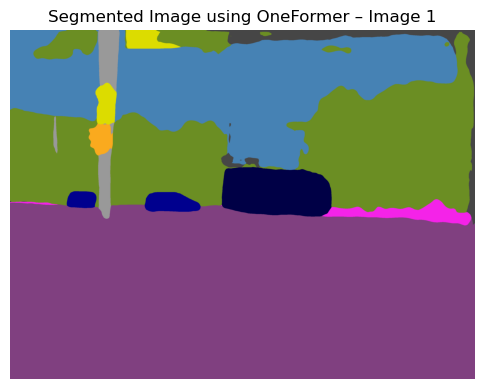

Labels for the first image:
[[10 10 10 ...  2  2  2]
 [10 10 10 ...  2  2  2]
 [10 10 10 ...  2  2  2]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [23]:
# Function to segment an image using OneFormer
def segment_image_with_oneformer(image, processor, oneformer, label_colors):
    original_size = image.size  # Original size of the image

    # Convert the image to a tensor and move it to the GPU
    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to("cuda")

    # Prepare the input for the model
    semantic_inputs = processor(images=image_tensor, task_inputs=["semantic"], return_tensors="pt").to("cuda")

    # Forward pass through the model
    with torch.no_grad():
        outputs = oneformer(**semantic_inputs)

    # Post-processing of the segmentation output
    predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[original_size[::-1]])[0]
    label_ids = predicted_semantic_map.cpu().numpy()  # Extract label IDs from model output

    # Create RGB image for visualization
    r, g, b = np.zeros_like(label_ids, dtype=np.uint8), np.zeros_like(label_ids, dtype=np.uint8), np.zeros_like(label_ids, dtype=np.uint8)

    # Set colors according to label mapping
    for l in range(len(label_colors)):
        idx = label_ids == l
        r[idx], g[idx], b[idx] = label_colors[l]

    rgb_image = np.stack([r, g, b], axis=2)  # Create RGB image

    # Release memory
    del image_tensor, outputs, semantic_inputs
    torch.cuda.empty_cache()

    return rgb_image, label_ids  # Return RGB image and label IDs

# Iterate over the dataset and save segmented images
for idx, image in enumerate(tqdm(ds_subset, desc="Segmenting images with OneFormer")):
    segmented_image, label_ids = segment_image_with_oneformer(image, processor, oneformer, label_colors)

    # Save the results as .npy files
    np.save(f"segmented_rgb_{idx}.npy", segmented_image)  # Save RGB image
    np.save(f"label_ids_{idx}.npy", label_ids)  # Save label IDs

    # Immediately free up memory
    del segmented_image, label_ids
    torch.cuda.empty_cache()

# Visualize the first segmented file
first_rgb = np.load("segmented_rgb_0.npy")  # Load the first RGB image
plt.figure(figsize=(6, 6))
plt.imshow(first_rgb)  # Display the image
plt.title("Segmented Image using OneFormer – Image 1")
plt.axis("off")
plt.show()

# Print label IDs for the first file
first_labels = np.load("label_ids_0.npy")
print("Labels for the first image:")
print(first_labels)

There are more images (805) than space in the grid (6x4)!


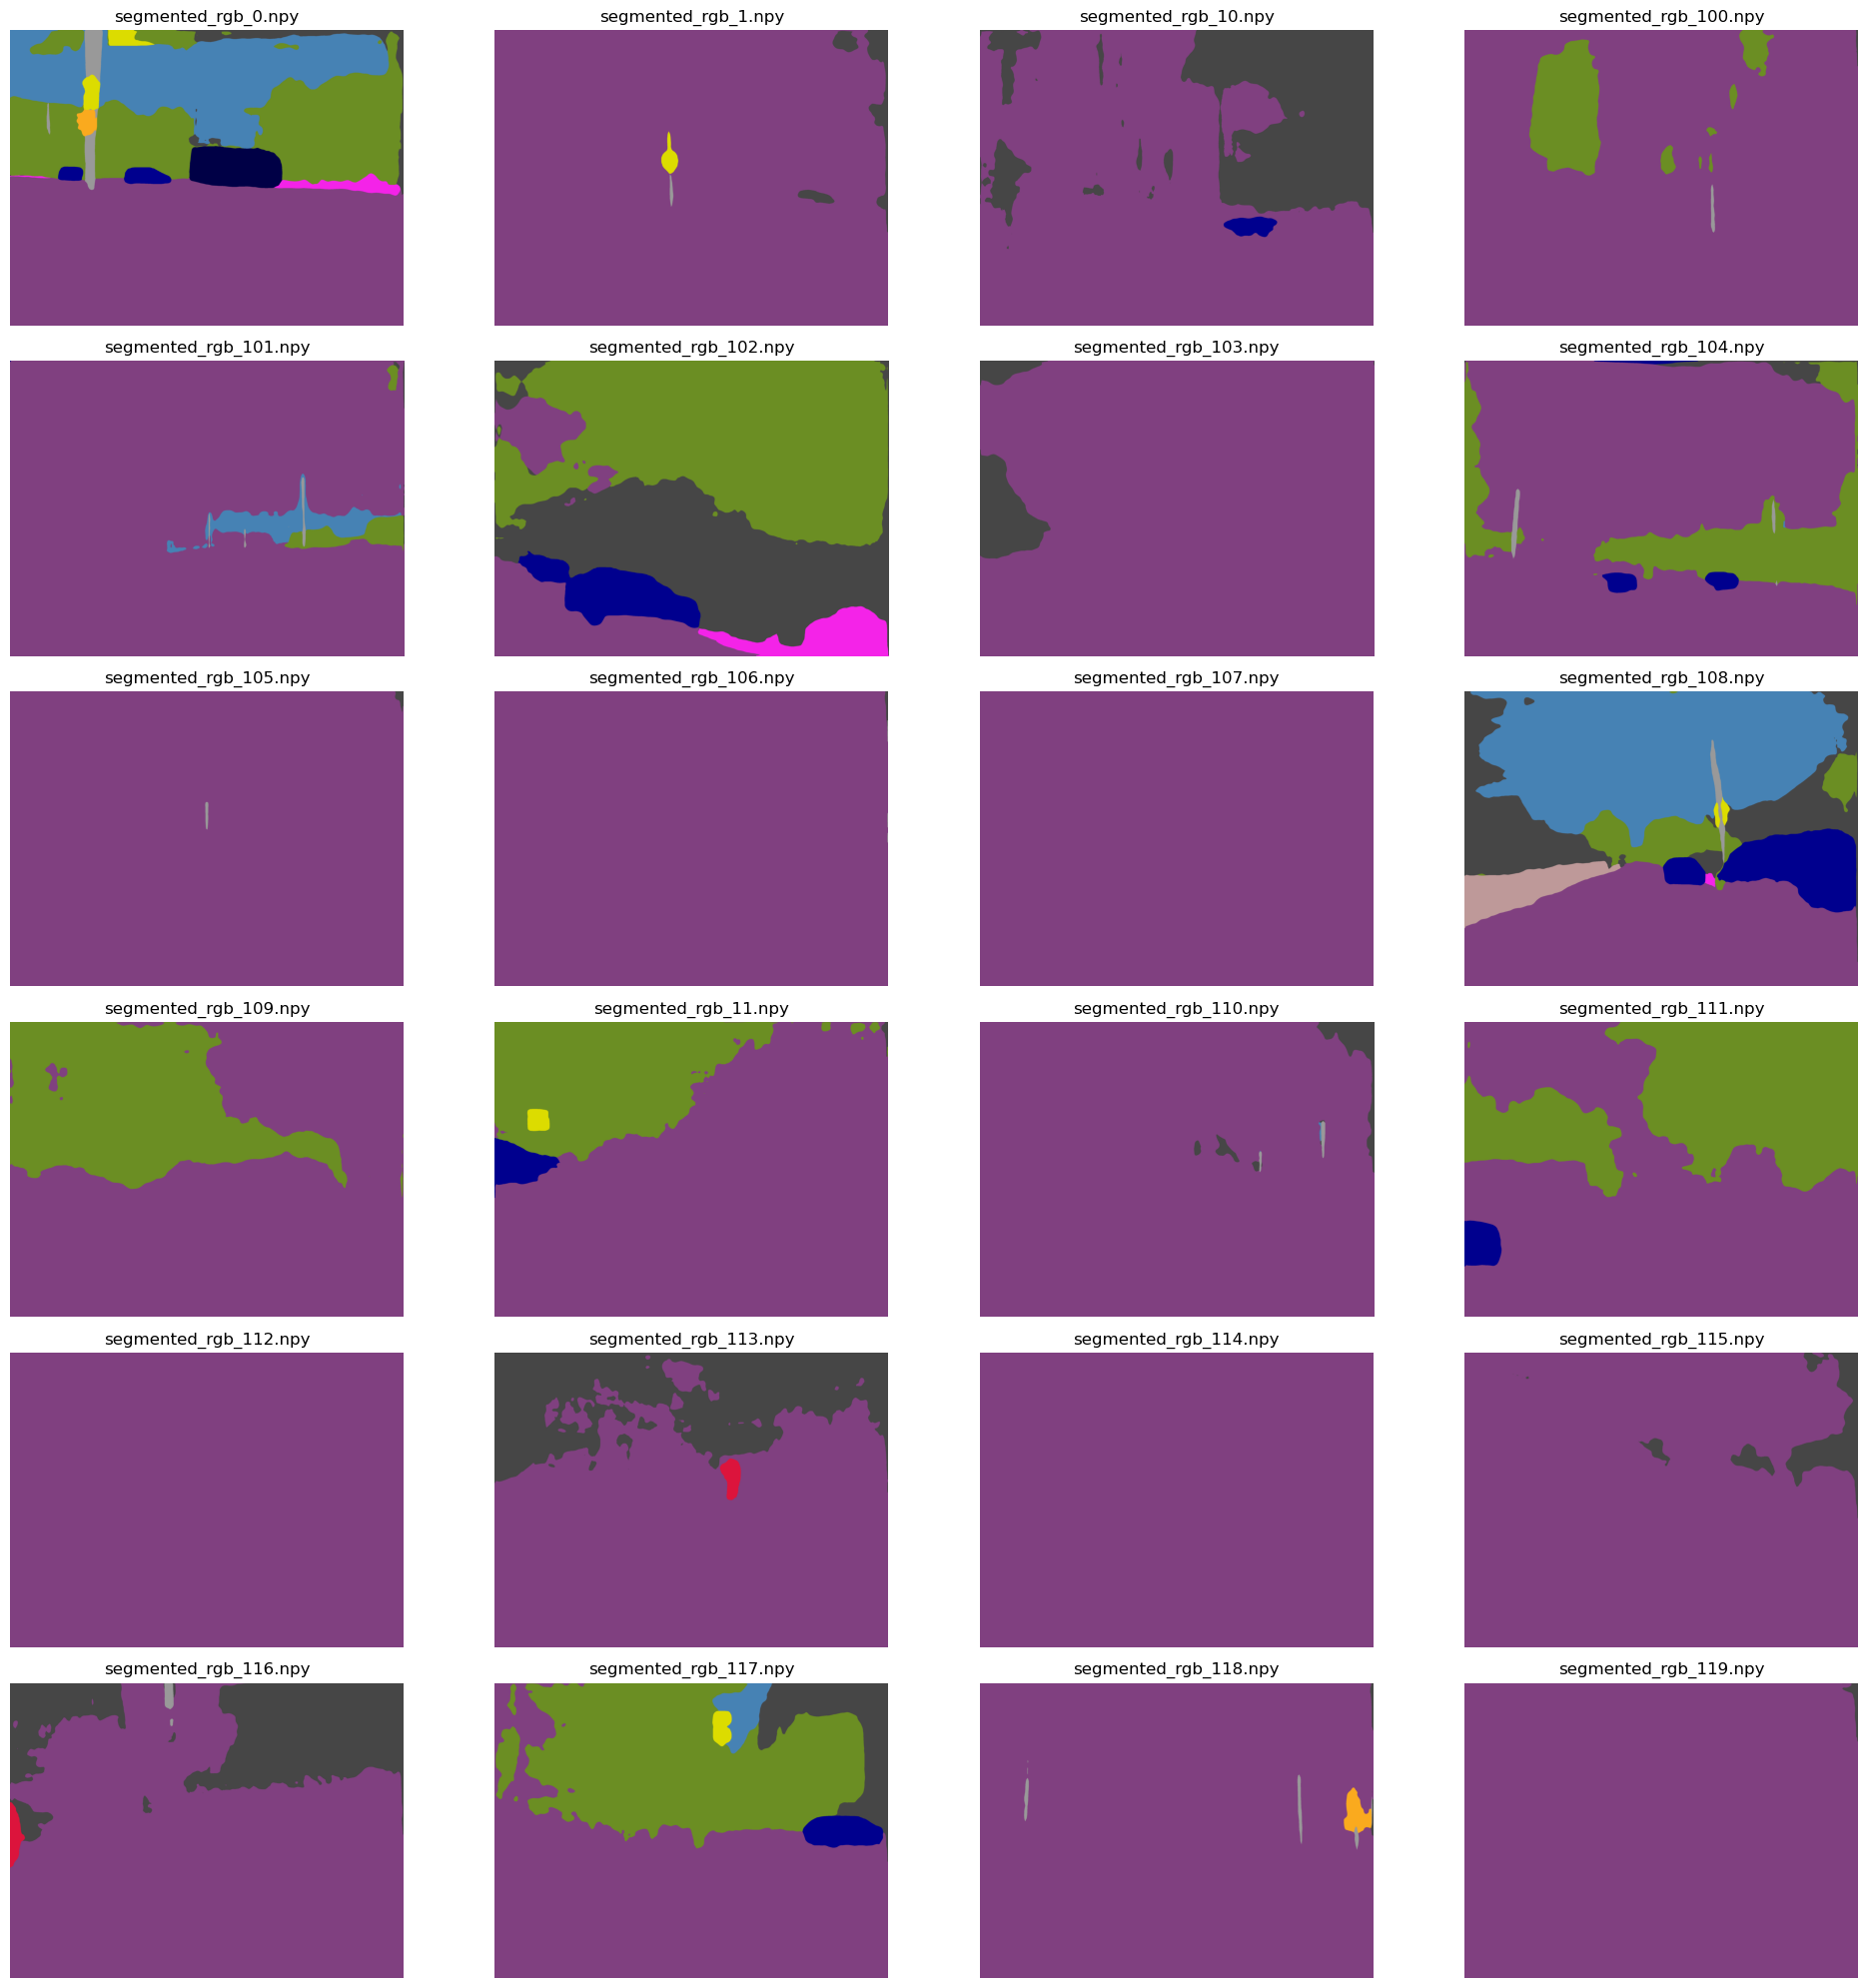

In [24]:
# Function to visualize all segmented images from saved .npy files
def display_all_segmentations(folder_path=".", rows=6, cols=4, figsize=(20, 20)):
    # Get a list of all saved RGB image files (sorted by index)
    rgb_files = sorted(glob.glob(f"{folder_path}/segmented_rgb_*.npy"))
    num_images = len(rgb_files)  # Number of available images

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten axes for easier iteration

    for idx, rgb_file in enumerate(rgb_files):
        if idx >= len(axes):  # If there are more images than space in the grid
            print(f"There are more images ({num_images}) than space in the grid ({rows}x{cols})!")
            break
        
        # Load RGB image from the file
        rgb_image = np.load(rgb_file)

        # Display the image in the plot
        axes[idx].imshow(rgb_image)
        axes[idx].set_title(f"{rgb_file.split('/')[-1]}")  # Only display the file name
        axes[idx].axis("off")

    # Disable unused axes
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display all saved segmentations
display_all_segmentations(rows=6, cols=4, figsize=(20, 20))

In [25]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get GPU details
    device = torch.device("cuda")
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    # Calculate free memory
    free_memory = total_memory - allocated_memory
    print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated GPU Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free GPU Memory: {free_memory / (1024 ** 3):.2f} GB")
    print(f"Cached GPU Memory: {cached_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Please check your GPU setup.")

Total GPU Memory: 14.54 GB
Allocated GPU Memory: 0.83 GB
Free GPU Memory: 13.71 GB
Cached GPU Memory: 0.86 GB


### Metrics

For quality evaluation, **Intersection over Union (IoU)** is used:
- IoU calculates the ratio of the intersection area to the union area of the segments.
- This quantifies the agreement between predicted and actual segments.

##### OneFormer

In [26]:
# Function to calculate IoU in percentage
def calculate_iou_percentage(pred_mask, true_mask, selected_classes):
    iou_results = {}
    
    for class_id in selected_classes:
        # Create binary masks for the selected classes
        pred_class_mask = (pred_mask == class_id).astype(int)
        true_class_mask = (true_mask == class_id).astype(int)

        # Calculate Intersection and Union
        intersection = np.sum(pred_class_mask * true_class_mask)
        union = np.sum(pred_class_mask) + np.sum(true_class_mask) - intersection

        # Calculate the IoU
        iou = intersection / union if union != 0 else 0
        iou_results[class_id] = iou * 100  # Convert to percentage
    
    return iou_results

In [27]:
# Load the first label ID file
first_labels = np.load("label_ids_0.npy")

# Print details about the loaded data
print("Filename: label_ids_0.npy")
print("\nValues:")
print(first_labels)
print("\nNumber of elements:", first_labels.size)

Filename: label_ids_0.npy

Values:
[[10 10 10 ...  2  2  2]
 [10 10 10 ...  2  2  2]
 [10 10 10 ...  2  2  2]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Number of elements: 7990272


In [28]:
# Initialize an empty set to store unique values
unique_values = set()  

# Iterate through all files matching the pattern "label_ids_*.npy"
for file in glob.glob("label_ids_*.npy"):
    # Load the label IDs from the file and update the set with unique values
    unique_values.update(np.load(file).ravel())

# Print the unique values found in the label IDs
print("\nUnique values in the label IDs:", unique_values)


Unique values in the label IDs: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)}


In [29]:
# Load the OneFormer model configuration with label names (to check)
model_config = oneformer.config  # OneFormer model configuration

label_names_from_config = model_config.id2label  # A dictionary mapping label ID to label names
print(label_names_from_config)

{0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky', 11: 'person', 12: 'rider', 13: 'car', 14: 'truck', 15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle'}


In [30]:
# Defined classes for IoU calculation
# Person, traffic light, traffic sign, bicycle, sidewalk, car
selected_classes = [11, 6, 7, 18, 1, 13]

# Empty dictionary to store IoU values in percentage
iou_results_percentage = {}

# Calculate IoU for each saved file
for idx in range(len(ds_subset)):  
    # Loaded segmented mask
    pred_mask = np.load(f"label_ids_{idx}.npy")  
    
    # Loaded ground truth mask
    true_mask = np.load(f"mask_{idx}.npy")  
    
    # Calculate IoU in percentage for the selected classes
    iou_for_image = calculate_iou_percentage(pred_mask, true_mask, selected_classes)
    
    # Store IoU values
    iou_results_percentage[f"image_{idx}"] = iou_for_image

# Output IoU values in percentage for each file
for image_name, iou_values in iou_results_percentage.items():
    # Convert np.float64 to regular float values
    iou_values = {k: float(v) for k, v in iou_values.items()}
    print(f"{image_name}: {iou_values}")

image_0: {11: 0.0, 6: 28.567549058965213, 7: 27.183790912360628, 18: 0.0, 1: 3.643268076652456, 13: 71.30860507650443}
image_1: {11: 0.0, 6: 0.0, 7: 62.83171903299473, 18: 0.0, 1: 0.0, 13: 0.0}
image_2: {11: 0.0, 6: 0.0, 7: 83.70808084609884, 18: 0.0, 1: 0.0, 13: 0.0}
image_3: {11: 0.0, 6: 0.0, 7: 28.394100180110016, 18: 0.0, 1: 0.0, 13: 0.0}
image_4: {11: 0.0, 6: 0.0, 7: 0.0, 18: 0.0, 1: 0.0, 13: 0.0}
image_5: {11: 23.022361421366558, 6: 0.0, 7: 0.0, 18: 0.0, 1: 0.0, 13: 18.995017900743786}
image_6: {11: 0.0, 6: 37.38850144859788, 7: 0.0, 18: 0.0, 1: 0.0, 13: 34.58259028087383}
image_7: {11: 0.0, 6: 0.0, 7: 0.0, 18: 0.0, 1: 0.0, 13: 70.97865210376071}
image_8: {11: 0.0, 6: 0.0, 7: 0.0, 18: 0.0, 1: 2.3595383865200192, 13: 0.0}
image_9: {11: 0.0, 6: 0.0, 7: 0.0, 18: 0.0, 1: 0.0, 13: 0.0}
image_10: {11: 0.0, 6: 0.0, 7: 0.0, 18: 0.0, 1: 0.0, 13: 13.084468735936552}
image_11: {11: 0.0, 6: 0.0, 7: 86.36714052237195, 18: 0.0, 1: 0.0, 13: 21.917232901970156}
image_12: {11: 0.0, 6: 0.0, 7: 0.0

In [31]:
# Empty dictionary to store the collected IoU values for each class
iou_per_class = {class_id: [] for class_id in selected_classes}

# Calculate IoU for each saved file
for idx in range(len(ds_subset)):  
    # Loaded segmented mask
    pred_mask = np.load(f"label_ids_{idx}.npy")  
    
    # Loaded ground truth mask
    true_mask = np.load(f"mask_{idx}.npy")  
    
    # Calculate IoU in percentage for the selected classes
    iou_for_image = calculate_iou_percentage(pred_mask, true_mask, selected_classes)
    
    # Add the IoU values to the respective class lists (only if IoU > 0)
    for class_id, iou in iou_for_image.items():
        if iou > 0:
            iou_per_class[class_id].append(iou)

# Calculate the average IoU for each class (only if values are available)
average_iou_per_class = {
    class_id: np.mean(iou_values) if iou_values else 0 
    for class_id, iou_values in iou_per_class.items()
}

# Output the average IoU values per class
for class_id, avg_iou in average_iou_per_class.items():
    print(f"Average IoU for class {class_id}: {avg_iou:.2f}%")

Average IoU for class 11: 28.56%
Average IoU for class 6: 30.17%
Average IoU for class 7: 47.06%
Average IoU for class 18: 39.01%
Average IoU for class 1: 13.84%
Average IoU for class 13: 39.65%


In [32]:
# Calculate the min and max IoU for each class (only if values are available)
min_max_iou_per_class = {
    class_id: (np.min(iou_values), np.max(iou_values)) if iou_values else (0, 0) 
    for class_id, iou_values in iou_per_class.items()
}

# Output the min and max IoU values per class in the format "min% - max%"
for class_id, (min_iou, max_iou) in min_max_iou_per_class.items():
    print(f"Class {class_id}: {min_iou:.2f}% - {max_iou:.2f}%")

Class 11: 0.17% - 78.00%
Class 6: 0.01% - 83.78%
Class 7: 0.01% - 94.68%
Class 18: 3.92% - 74.06%
Class 1: 0.01% - 77.74%
Class 13: 0.00% - 95.18%


#### What explains the observed IoU variability (min vs. max)?
##### Example: Class 7 (Traffic Sign, Front) – compare image_173 (6.3% IoU) with image_256 (94.6% IoU).


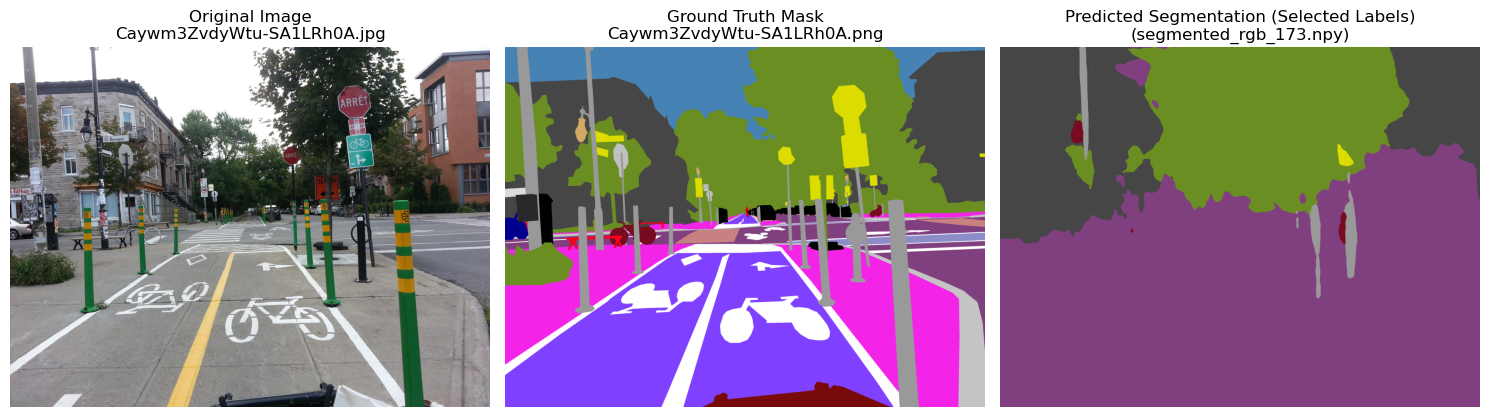

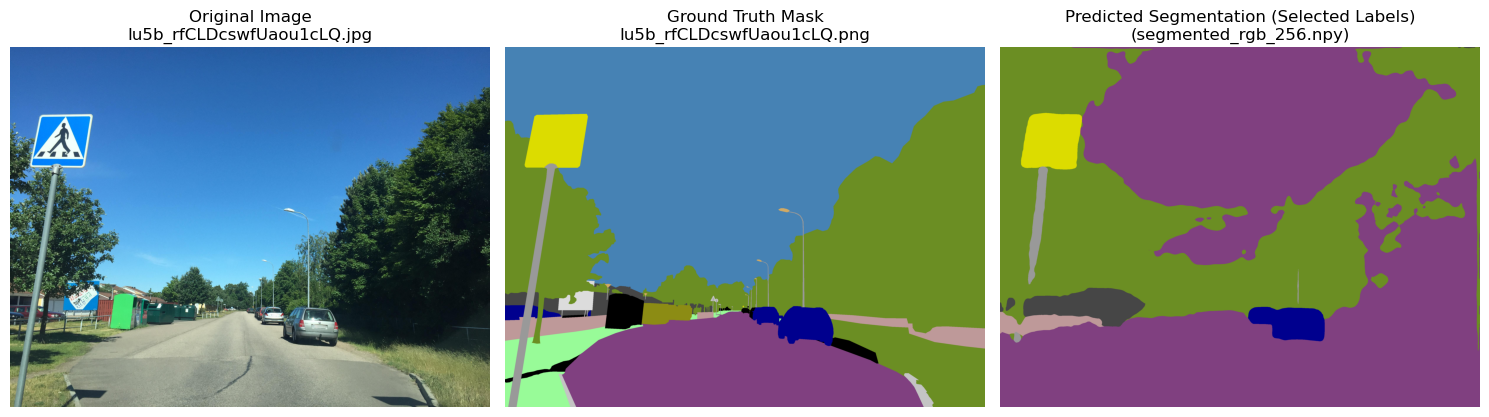

In [33]:
def display_segmentation_comparison(image_indices, image_filenames, label_filenames, image_folder="images", label_folder="labels", folder_path="."):
    for idx in image_indices:
        shifted_idx = idx - 1  # Adjust index to match saved .npy files

        fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

        try:
            # Load original image
            original_path = os.path.join(image_folder, image_filenames[idx])
            original = Image.open(original_path).convert("RGB")

            # Load ground truth mask
            label_path = os.path.join(label_folder, label_filenames[idx])
            gt_mask = Image.open(label_path)

            # Load segmented RGB output
            rgb_seg = np.load(os.path.join(folder_path, f"segmented_rgb_{shifted_idx}.npy"))

        except FileNotFoundError as e:
            print(f"Missing file for image {idx}: {e}")
            continue

        # Display original image
        axes[0].imshow(original)
        axes[0].set_title(f"Original Image\n{image_filenames[idx]}")
        axes[0].axis("off")

        # Display ground truth mask
        axes[1].imshow(gt_mask, cmap="nipy_spectral")
        axes[1].set_title(f"Ground Truth Mask\n{label_filenames[idx]}")
        axes[1].axis("off")

        # Display segmented RGB output
        axes[2].imshow(rgb_seg)
        axes[2].set_title(f"Predicted Segmentation (Selected Labels)\n(segmented_rgb_{shifted_idx}.npy)")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Sorted file lists
image_filenames = sorted(os.listdir("images"))
label_filenames = sorted(os.listdir("labels"))

# Display for images 173 and 256
display_segmentation_comparison([174, 257], image_filenames, label_filenames)


Explanation of IoU Variability for Class 7 (Traffic Sign, Front)
The large discrepancy in IoU between image_173 (6.3%) and image_256 (94.6%) is primarily explained by differences in object visibility, scene complexity, and semantic clarity.

In image_173, traffic signs are small, partially occluded by vertical structures, and embedded in a cluttered urban scene. These factors reduce the model’s ability to distinguish object boundaries. In contrast, image_256 contains a single, well-lit sign with strong contrast and minimal contextual noise, aligning closely with the model’s learned representations.

Thus, the low IoU is attributable to occlusion, scale variation, and background clutter, while the high IoU benefits from salient appearance and isolated context.

<sup>1</sup> Transformer-based segmentation models, such as OneFormer, show improved global reasoning but still struggle with fine-grained localization of small or occluded objects due to limited resolution in deeper layers and reliance on dominant features.

### Obeservations
**Image 173 – Low IoU (Traffic sign; 6.3%)**
- Small, thin traffic signs difficult to detect
- Partial occlusion by poles and structures
- High visual clutter in urban environment
- Low contrast between signs and background
- Atypical layout not well represented in training data

**Image 256 – High IoU (Traffic sign; 94.6%)**
- Large, clearly visible traffic sign
- No occlusion; isolated object
- Low scene complexity with clean background
- High contrast (e.g., yellow sign on blue sky)
- Typical configuration aligned with training distribution

### Overview

#### Performance Evaluation Across All Predictions
The average IoU values are as follows: 
- Sidewalk: 13.84%
- Person: 28.56%
- Traffic Light: 30.17%
- Traffic Sign (Front): 47.06%
- Bicycle: 39.01 %
- Car: 39.65%

There are large differences between the average IoU of the labels, as expected, with larger objects generally achieving higher IoU scores and smaller, more complex objects showing lower IoU values due to segmentation challenges such as unclear boundaries and occlusions. Upon reviewing the individual IoU results of the images, the outcomes appear reasonable. Benchmarks on the Mapillary validation dataset indicate that the OneFormer with a DiNAT-L backbone reaches an mIoU of 64.9% when using multi-scale inference.

#### Memory evaluation over all predictions

In [34]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get GPU details
    device = torch.device("cuda")
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    # Calculate free memory
    free_memory = total_memory - allocated_memory
    print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated GPU Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free GPU Memory: {free_memory / (1024 ** 3):.2f} GB")
    print(f"Cached GPU Memory: {cached_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Please check your GPU setup.")

Total GPU Memory: 14.54 GB
Allocated GPU Memory: 0.83 GB
Free GPU Memory: 13.71 GB
Cached GPU Memory: 0.86 GB


#### Speed Evaluation Across All Predictions

As part of a project outside the bachelor thesis, OneFormer was previously tested. The segmentation at the original size took 4 minutes and 12 seconds for only 19 iterations (averaging 13.29 seconds per iteration).

Since a significantly larger subset was planned for this bachelor project, global and batch processing techniques were integrated to avoid memory errors and reduce runtime. Instead of sequential processing, parallel processing is now applied to handle large datasets more efficiently.
    
**Differences between sequential and global/batch processing:**
- **Sequential**: Data is processed one by one, leading to higher memory requirements and longer runtimes.
- **Global**: All data is processed at once, optimizing parallelization.
- **Batch**: Data is processed in batches, which uses memory efficiently and speeds up runtime.

Fortunately, this processing allows the subset size to be increased while maintaining stable performance.

**Speed Evaluation in Bullets (for Notebook):**
- The OneFormer segmentation at original size averaged 13.29 seconds per iteration in sequential processing.
- After using batch processing: Segmentation at original size took only 3.82 seconds per iteration.

#### Evaluation of Segmentation Results: IoU Based on Label Size

The accuracy of semantic segmentation models varies significantly with object size, affecting the Intersection over Union (IoU) metric. Small objects tend to exhibit lower IoU values due to scaling issues and frequent misdetections, whereas objects with unclear boundaries, such as sidewalks or background regions, often suffer from classification ambiguities and reduced overlap with ground truth segments. In contrast, large and well-defined objects, such as cars, achieve higher IoU scores as their shape and spatial extent facilitate more precise segmentation.

To illustrate these effects, this analysis investigates the relationship between object size and IoU values by categorizing segmented objects into small, medium, and large classes. It is expected that smaller objects, being more susceptible to distortions, yield lower IoU scores, while larger objects benefit from greater stability and accuracy in segmentation.

In [35]:
# Average dimensions for each class (height and width)
# The average values for dimensions (height and width) are sourced from the Mapillary Vistas Dataset, as documented by Dataset Ninja (2025) [https://datasetninja.com/mapillary-vistas-dataset].
avg_dimensions = {
    15: {'name': 'Sidewalk', 'avg_height': 301, 'avg_width': 1098},
    19: {'name': 'Person', 'avg_height': 147, 'avg_width': 61},
    48: {'name': 'Traffic Light', 'avg_height': 88, 'avg_width': 42},
    50: {'name': 'Traffic Sign (Front)', 'avg_height': 56, 'avg_width': 51},
    52: {'name': 'Bicycle', 'avg_height': 149, 'avg_width': 125},
    55: {'name': 'Car', 'avg_height': 139, 'avg_width': 190}
}

# Example IoU values for each class
# These values should come from the IoU calculations
iou_results = {
    15: 13.84,   # Sidewalk
    19: 28.56,   # Person
    48: 30.17,   # Traffic Light
    50: 47.06,   # Traffic Sign (Front)
    52: 39.01,   # Bicycle
    55: 39.65    # Car
}

# Calculate area (average height * average width)
for class_id in avg_dimensions:
    height = avg_dimensions[class_id]['avg_height']
    width = avg_dimensions[class_id]['avg_width']
    avg_dimensions[class_id]['area'] = height * width

# Prepare data for correlation analysis
areas = [avg_dimensions[class_id]['area'] for class_id in avg_dimensions]
ious = [iou_results[class_id] for class_id in avg_dimensions]

# Compute Pearson correlation coefficient
corr_coefficient, p_value = stats.pearsonr(areas, ious)

# Print results
print(f"Pearson Correlation Coefficient: {corr_coefficient:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpretation of results
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Pearson Correlation Coefficient: -0.80
P-value: 0.0540
The correlation is not statistically significant.


A negative correlation means that as one variable increases, the other tends to decrease. In this case, a negative correlation between object size and IoU would imply that as the size of the object increases, the IoU value tends to decrease, or vice versa.

The negative correlation between object size and IoU is strong but not statistically significant, as indicated by the p-value of 0.0540. This suggests that while the trend may exist, it is not robust enough to confirm a clear relationship. It could imply that factors like unclear object boundaries or misdetections in larger objects, occlusions, or variations in object appearance due to environmental factors (e.g., lighting, distance, or angle) may contribute to the lower IoU values for larger objects.